# Chapter 5: Support vector machines

A Support Vector Machine (SVM) is one of the most popular machine learning models, able to perform many types of learning, from linear and nonlinear classification, regression, and outlier detection. They are particularly well-suited for complex but small/medium datasets.

## Linear SVM classification

SVMs fit the largest possible "street" between the classes. This is called *large margin classification*. The decision boundary is not affected by adding more training instances outside the boundary ("off the street"). The boundary is fully determined by the instances that are on the "edge of the street". These instances are called the *support vectors*.

Note that SVMs are sensitive to feature scaling.

## Soft margin classification

In *hard margin classification*, we strictly impose that all instances be off the street and on the right side. However this only works if the data is linearly separable, and it is sensitive to outliers. To avoid this, it is preferable to work with a model in which we keep the street as large as possible and try to limit *margin violations* (rather than strictly). This is called *soft margin classification*.

In the Scikit-Learn SVM class, the balance between keeping the street large and minimizing margin violations is controled with the hyperparameter C. Smaller C leads to a larger street, larger C leads to fewer margin violations.

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline


iris = datasets.load_iris()
X = iris["data"][:, (2,3)] #petal length and petal width
y_bool = (iris["target"] == 2)
y = y_bool.astype(np.float64) #1 for Iris-V, 0 otherwise

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [2]:
svm_clf.predict([[5.5,1.7]])

array([1.])

Now we want to classify between the Iris-Virginica and the Iris-Versicolor species

In [3]:
iris["target_names"]

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
initial_species_filter = (iris["target"]==1) | (iris["target"]==2) #create bool to select only Virginica and Versicolor
y = (iris["target"][initial_species_filter]==2).astype(np.float64) # 1 for Iris-Virginica, 0 for -Versicolor
X = iris["data"][initial_species_filter, 2:] #select petal length and width, Iris-Virginica and -Versicolor

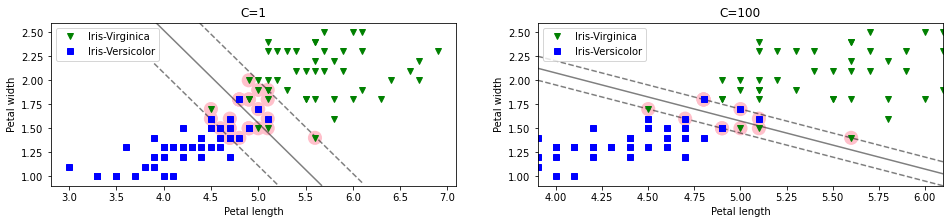

In [5]:
from sklearn.svm import SVC

clf = SVC(C=1, kernel="linear");
clf.fit(X,y);
xx, yy = np.meshgrid(np.linspace(3.9, 6.1,100), np.linspace(0.9, 2.6, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
support_vectors = clf.support_vectors_

fig, (ax1,ax2) = plt.subplots(figsize=(16,3), nrows=1,ncols=2)
ax1.plot(X[y==1,0],X[y==1,1], 'gv', label="Iris-Virginica")
ax1.plot(X[y==0,0],X[y==0,1], 'bs',label="Iris-Versicolor")
plt.ylim(0.9, 2.6)
plt.xlim(3.9, 6.1)
ax1.contour(xx, yy, Z, colors="k", levels=[-1, 0, 1],  alpha=0.5,linestyles=["--", "-", "--"], )
ax1.scatter(support_vectors[:, 0], support_vectors[:, 1],
        s=200, linewidth=2, facecolors="pink", edgecolors="none", )
ax1.legend()
ax1.set_xlabel("Petal length");
ax1.set_ylabel("Petal width");
ax1.set_title("C=1");

clf = SVC(C=100, kernel="linear");
clf.fit(X,y);
#xx, yy = np.meshgrid(np.linspace(3.9, 6.1,100), np.linspace(0.9, 2.6, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
support_vectors = clf.support_vectors_

ax2.plot(X[y==1,0],X[y==1,1], 'gv', label="Iris-Virginica")
ax2.plot(X[y==0,0],X[y==0,1], 'bs',label="Iris-Versicolor")
plt.ylim(0.9, 2.6)
plt.xlim(3.9, 6.1)
ax2.contour(xx, yy, Z, colors="k", levels=[-1, 0, 1],  alpha=0.5,linestyles=["--", "-", "--"], )
ax2.scatter(support_vectors[:, 0], support_vectors[:, 1],
        s=200, linewidth=2, facecolors="pink", edgecolors="none", )
ax2.legend()
ax2.set_xlabel("Petal length");
ax2.set_ylabel("Petal width");
ax2.set_title("C=100");


## Nonlinear SVM classification

In cases where datasets are not linearly separable, there are several options. One is to add more features, such as polynomials of existing features, which sometimes results in a separable dataset. This can be implemented in Scikit-Learn as in the following:

In [6]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(C=10, kernel='linear'))
])

X,y = make_moons(n_samples=100, noise=0.1)
polynomial_svm_clf.fit(X,y)

xx, yy = np.meshgrid(np.linspace(-1.5,2.4, 100),np.linspace(-1, 1.5,100))
Z = polynomial_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


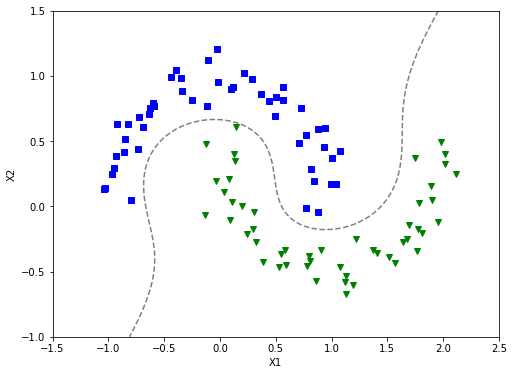

In [7]:
plt.subplots(figsize=(8,6))
plt.plot(X[y==0,0],X[y==0,1], 'bs')
plt.plot(X[y==1,0], X[y==1,1], 'gv')
plt.contour(xx, yy, Z, colors="k", levels=[0],  alpha=0.5,linestyles=["--", "-", "--"], )
plt.xlabel("X1")
plt.ylabel("X2")
plt.ylim(-1,1.5);
plt.xlim(-1.5,2.5);

## Polynomial kernel

While adding polynomial features can work very well in many cases, for some complex datasets, it sometimes requires a high polynomial degree. This means adding a large number of features, which can slow the model down.

We're in luck, we can use the *kernel trick*. It can be implemented with the SVC class, as shown below.

In [8]:
from sklearn.svm import SVC
poly_kernel_svm_clf1 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3,coef0=1, C=5))
])


xx, yy = np.meshgrid(np.linspace(-1.5,2.4, 100),np.linspace(-1, 1.5,100))
X,y = make_moons(n_samples=100, noise=0.1)


poly_kernel_svm_clf1.fit(X,y)
Z1 = poly_kernel_svm_clf1.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)


poly_kernel_svm_clf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=10,coef0=100, C=5))
])

poly_kernel_svm_clf2.fit(X,y)
Z2 = poly_kernel_svm_clf2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)



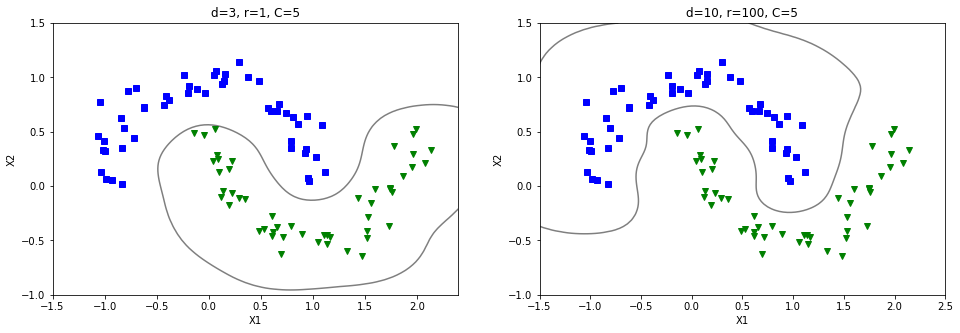

In [26]:
fig, (ax1,ax2) = plt.subplots(figsize=(16,5), nrows=1,ncols=2)
ax1.plot(X[y==0,0],X[y==0,1], 'bs')
ax1.plot(X[y==1,0], X[y==1,1], 'gv')
plt.ylim(-1,1.5);
plt.xlim(-1.5,2.5);
ax1.contour(xx, yy, Z1, colors="k", levels=[0],  alpha=0.5,linestyles=["-"], )
#ax1.scatter(support_vectors[:, 0], support_vectors[:, 1],
#        s=200, linewidth=2, facecolors="pink", edgecolors="none", )
#ax1.legend()
ax1.set_xlabel("X1");
ax1.set_ylabel("X2");
ax1.set_title("d=3, r=1, C=5");

#clf = SVC(C=100, kernel="linear");
#clf.fit(X,y);
#xx, yy = np.meshgrid(np.linspace(3.9, 6.1,100), np.linspace(0.9, 2.6, 100))
#Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)
#support_vectors = clf.support_vectors_

ax2.plot(X[y==0,0],X[y==0,1], 'bs')
ax2.plot(X[y==1,0], X[y==1,1], 'gv')
plt.ylim(-1,1.5);
plt.xlim(-1.5,2.5);
ax2.contour(xx, yy, Z2, colors="k", levels=[0],  alpha=0.5,linestyles=[ "-"], )
#ax2.scatter(support_vectors[:, 0], support_vectors[:, 1],
#        s=200, linewidth=2, facecolors="pink", edgecolors="none", )
#ax2.legend()
ax2.set_xlabel("X1");
ax2.set_ylabel("X2");
ax2.set_title("d=10, r=100, C=5");



## Adding similarity features

Add features from a *similarity function* that measure the resemblance between each instance and a *landmark*. One such similarity function is the Gaussian Radial Basis Function (RBF). It's a bell-shaped function varying from 1 (at the landmark) to 0 (very far from the landmark). Changing $\gamma$ affects the width of the bell curve.

$$\phi_{\gamma} (x, l) = \mathrm{exp}(-\gamma |x-l|^2)$$

Landmarks are chosen, and the dataset is transformed into new features. Selecting landmarks can be tricky. The simplest approach is to create a landmark at each instance in the dataset. This increases the chance of the new transformed dataset being separable. However, it can be computationally slow, since a large training set turned into a transformed set with a large number of features.

This can be overcome with another kernel trick. 

### Gaussian RBF kernel with SVC class

The larger gamma, the narrower the bell curve and the more limited the range of the influence of each instance. This results in a decision boundary that wiggles around each individual instance. A smaller gamma gives a wider bell curve, and a smoother, more regular decision boundary.

Other kernels exist, but are usually only used in specific circumstances with specific data structures, such as string kernels for IDing text documents or DNA sequences. In general, always try linearSVC first. If the training set is not too large, you can also try Gaussian RBF kernel. Then, if time allows (and computing power) then you can experiment wiht other kernels, using cross-validation and grid search.

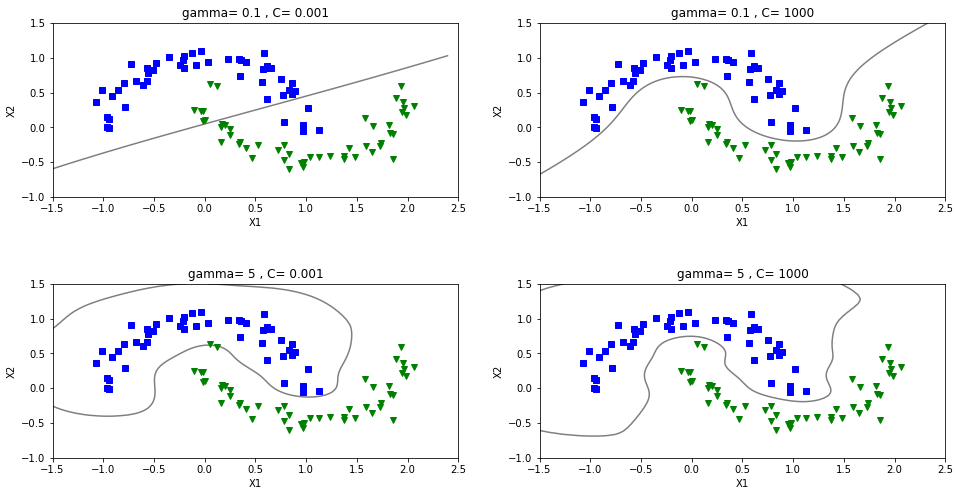

In [27]:
xx, yy = np.meshgrid(np.linspace(-1.5,2.4, 100),np.linspace(-1, 1.5,100))
X,y = make_moons(n_samples=100, noise=0.1)

fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(hspace=0.5)

c=1
for gamma, C in [[0.1,0.001], [0.1, 1000], [5,0.001], [5, 1000]]:
    plt.subplot(2,2,c)
    
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='rbf', gamma=gamma, C=C))
    ])
    rbf_kernel_svm_clf.fit(X,y)
    Z = rbf_kernel_svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.plot(X[y==0,0],X[y==0,1], 'bs')
    plt.plot(X[y==1,0], X[y==1,1], 'gv')
    plt.ylim(-1,1.5);
    plt.xlim(-1.5,2.5);
    plt.contour(xx, yy, Z, colors="k", levels=[0],  alpha=0.5,linestyles=["-"], )
    plt.xlabel("X1");
    plt.ylabel("X2");
    plt.title('gamma= {} , C= {}'.format(gamma, C));
    c=c+1
plt.show()



### Computation complexity

The LinearSVC class is based on the *liblinear* library, implementing an algorithm optimized for linear SVMs. It does not support the kernel trick. It scales ~linearly with the number of training instances in the data, and with the number of features. Training time is ~$O(m$x$n)$. It takes longer if you need very high precision, controlled by the hyperparameter $\epsilon$ (tol in Scikit-Learn). The default value is usually fine for most classification tasks.

In contrast, the SVC class is based on the *libsvm* library, which supports the kernel trick. Training time is usually $O(m^2$x$n)$ - $O(m^3$x$n)$, which means it can be very slow when the number of training instances gets large (100,000s). It is perfect for small-medium, complex training sets. It also scales well with the number of features (particularly sparse features). 

## SVM Regression

SVM also supports linear and non-linear regression, in addition to linear and non-linear classification. SvM Regression is done by reversing the objective: try to fit as many instances as possible *on* the street, still limiting the margin violations. (Instead of trying to fit the widest possible street while limiting margin violations). The street width is a hyperparameter $\epsilon$. The model is not sensitive to adding more training instances within the margin.

Scikit-Learn's LinearSVR class performs linear SVM regression.


In [124]:
from sklearn.svm import LinearSVR


In [125]:
X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1)


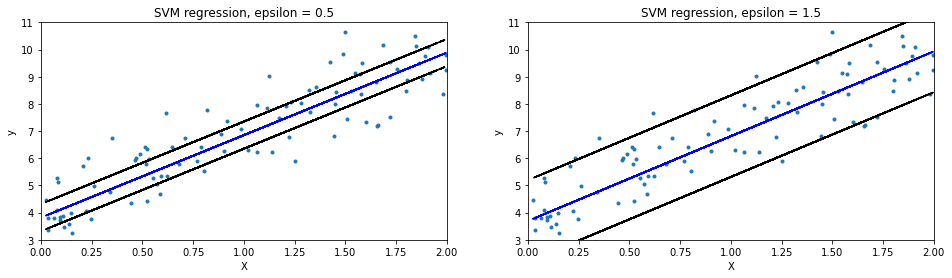

In [126]:
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(hspace=0.5)

c=1
for epsilon in [0.5, 1.5]:
    plt.subplot(1,2,c)
    
    svm_reg = LinearSVR(epsilon=epsilon,fit_intercept=True)
    svm_reg.fit(X,y.ravel())

    plt.plot(X, y, '.');
    plt.ylim(3,11);
    plt.xlim(0,2);
    plt.plot(X, svm_reg.predict(X),'b-');
    plt.plot(X, svm_reg.predict(X)+epsilon,linestyle='--', color='black');
    plt.plot(X, svm_reg.predict(X)-epsilon,linestyle='--', color='black');
    plt.title('SVM regression, epsilon = {}'.format(epsilon));
    plt.xlabel('X');
    plt.ylabel('y');
    c=c+1
plt.show()

For nonlinear regressions, we use a kernelized SVM model. Here we show an example on a quadratic training set, with a 2nd degree polynomial kernel.

In [127]:
from sklearn.svm import SVR

In [252]:
m = 100
#X =2* np.random.rand(m,1)-1
X = np.linspace(-1,1,100)
y = 0.5*X**2 + np.random.uniform(-.2, .2, len(X))

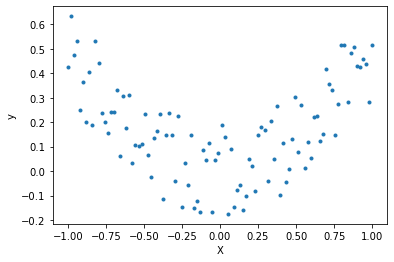

In [254]:
plt.plot(X, y,'.')
plt.xlabel("X")
plt.ylabel("y")
#plt.xlim(-2,2)
#plt.ylim(0,2)
plt.show()


In [257]:
svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X.reshape(-1, 1),y)

SVR(C=100, degree=2, kernel='poly')

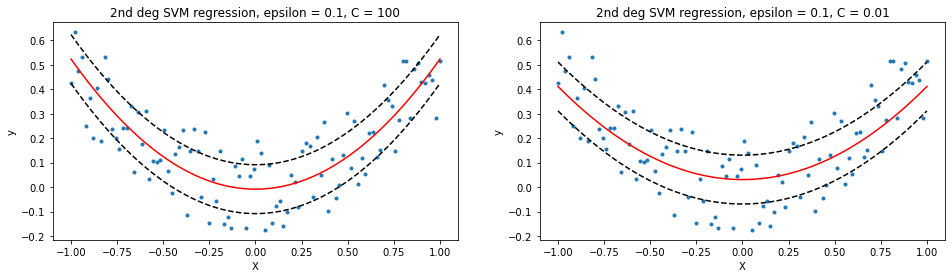

In [262]:
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(hspace=0.5)

c=1
for C, epsilon in [[100,0.1],[0.01,0.1]]:
    plt.subplot(1,2,c)
    
    svm_poly_reg = SVR(kernel='poly', degree=2, C=C, epsilon=epsilon)
    svm_poly_reg.fit(X.reshape(-1, 1),y);

    plt.plot(X, y, '.');
    #plt.ylim(0,11);
   # plt.xlim(-1,2);
    plt.plot(X, svm_poly_reg.predict(X.reshape(-1, 1)),'r-');
    plt.plot(X, svm_poly_reg.predict(X.reshape(-1, 1))+epsilon,'--', color='black');
    plt.plot(X, svm_poly_reg.predict(X.reshape(-1, 1))-epsilon,'--', color='black');
    plt.title('2nd deg SVM regression, epsilon = {}, C = {}'.format(epsilon,C));
    plt.xlabel('X');
    plt.ylabel('y');
    c=c+1
plt.show()

## Under the hood

We will now explore how SVM algorithms work under the hood, and how they make predictions.

The bias term will now be called *b* and the feature weight vector w.

### Decision function and predictions

The linear classifier model SVM predicts the class of a new instance x by computing the decision function $w^Tx+b$. If the result is positive, x is predicted to be in the positive (1) class, if it is negative, x is predicted to be in the negative (0) class. Training a linear SVM classifier means finding the value of w and b such that the margin is as wide as possible but with the fewest number of violations.
